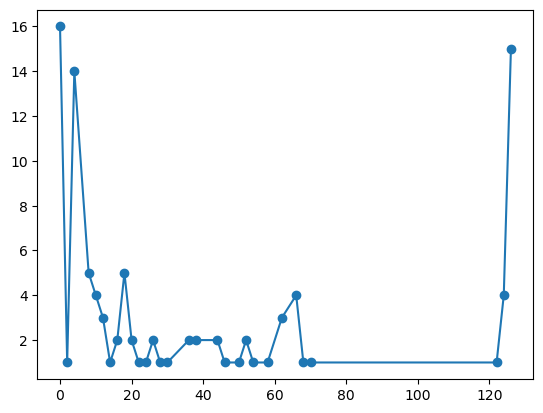

In [3]:
import cirq
import random
import numpy as np
import copy
import sympy
import itertools
from matplotlib import pyplot as plt

number_qubits = 7
iterator = 50

#A basic, one-dimensional quantum random walk implemented in Cirq

#There will be a qubit allocated which will be flipped by the "quantum coin", and will tell the random walk whether to jump left or right
#The position vector for a 2^N node random walk will be encoded using N qubits

qubits = []
for i in range(0, number_qubits):
    qubits.append(cirq.GridQubit(0, i))

ancilla = []
for i in range(0, number_qubits+2):
    ancilla.append(cirq.GridQubit(1, i))

def apply_n_qubit_tof(ancilla, args):

    if (len(args) == 2):
        yield cirq.CNOT.on(args[0], args[1])

    elif (len(args) == 3):
        yield cirq.CCX.on(args[0], args[1], args[2])

    else:

        yield cirq.CCX.on(args[0], args[1], ancilla[0])
        for k in range(2, len(args)-1):
            yield cirq.CCX(args[k], ancilla[k-2], ancilla[k-1])

        yield cirq.CNOT.on(ancilla[len(args)-3], args[len(args)-1])

        for k in range(len(args)-2, 1, -1):
            yield cirq.CCX(args[k], ancilla[k-2], ancilla[k-1])
        yield cirq.CCX.on(args[0], args[1], ancilla[0])

def initial_state():

    yield cirq.X.on(cirq.GridQubit(0, 1))
    #Make the even initial state for the coin-flip qubit


    yield cirq.X.on(cirq.GridQubit(0, number_qubits))
def walk_step():
    
    #Start by applying the coin operator to the flip qubit

    #Implement the Addition Operator

    yield cirq.H.on(cirq.GridQubit(0, number_qubits))

    yield cirq.X.on(cirq.GridQubit(0, number_qubits))

    for i in range(number_qubits, 0, -1):

        yield apply_n_qubit_tof(ancilla, [cirq.GridQubit(0, v) for v in range(number_qubits, i-2, -1)])
        yield cirq.X.on(cirq.GridQubit(0, i-1))

    for i in range(number_qubits+1, 1, -1):
        yield cirq.X.on(cirq.GridQubit(0, i-1))

    #Implement the Substraction Operator

    yield cirq.X.on(cirq.GridQubit(0, number_qubits))

    for i in range(number_qubits+1, 1, -1):
        yield cirq.X.on(cirq.GridQubit(0, i-1))

    for i in range(1, number_qubits+1):

        yield apply_n_qubit_tof(ancilla, [cirq.GridQubit(0, v) for v in range(number_qubits, i-2, -1)])
        yield cirq.X.on(cirq.GridQubit(0, i-1))

circuit = cirq.Circuit()

circuit.append(initial_state())

for j in range(0, iterator):
    circuit.append(walk_step())
circuit.append(cirq.measure(*qubits, key='x'))

simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=100)
final = result.histogram(key='x')

x_arr = [j for j in dict(final).keys()]
y_arr = [dict(final)[j] for j in dict(final).keys()]

x_arr_final = []
y_arr_final = []

while (len(x_arr) > 0):

    x_arr_final.append(min(x_arr))
    y_arr_final.append(y_arr[x_arr.index(min(x_arr))])
    holder = x_arr.index(min(x_arr))
    del x_arr[holder]
    del y_arr[holder]

plt.plot(x_arr_final, y_arr_final)
plt.scatter(x_arr_final, y_arr_final)
plt.show()

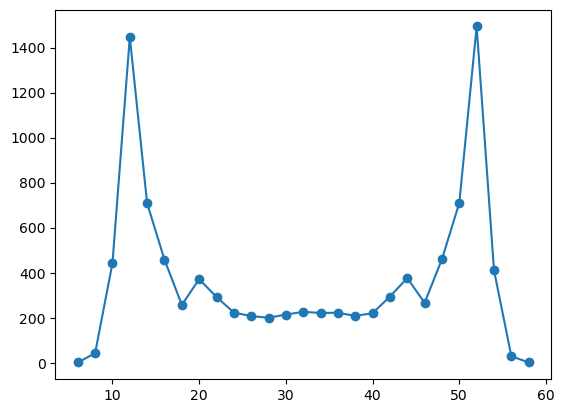

In [9]:
def walk_step():

    # "Flip" the coin vector

    yield cirq.H.on(cirq.GridQubit(0, number_qubits))

    # Implement the Addition Operator

    yield cirq.X.on(cirq.GridQubit(0, number_qubits))

    for i in range(number_qubits, 0, -1):

        controls = [cirq.GridQubit(0, v) for v in range(number_qubits, i-1, -1)]
        yield cirq.X.on(cirq.GridQubit(0, i-1)).controlled_by(*controls)
        if (i > 1):
            yield cirq.X.on(cirq.GridQubit(0, i-1))

    yield cirq.X.on(cirq.GridQubit(0, number_qubits))

    # Implement the Subtraction Operator

    for i in range(1, number_qubits+1):

        controls = [cirq.GridQubit(0, v) for v in range(number_qubits, i-1, -1)]
        yield cirq.X.on(cirq.GridQubit(0, i-1)).controlled_by(*controls)
        if (i < number_qubits):
            yield cirq.X.on(cirq.GridQubit(0, i))

def generate_walk(number_qubits, iterator, sample_number):

    circuit = cirq.Circuit()

    circuit.append(initial_state())
    for j in range(iterator):
        circuit.append(walk_step())
    circuit.append(cirq.measure(*qubits, key='x'))

    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=sample_number)
    final = result.histogram(key='x')

    return final

def graph(final):

    x_arr = list(final.keys())
    y_arr = [dict(final)[j] for j in dict(final).keys()]

    x_arr_final = []
    y_arr_final = []

    while (len(x_arr) > 0):

        x_arr_final.append(min(x_arr))
        y_arr_final.append(y_arr[x_arr.index(min(x_arr))])
        holder = x_arr.index(min(x_arr))
        del x_arr[holder]
        del y_arr[holder]

    plt.plot(x_arr_final, y_arr_final)
    plt.scatter(x_arr_final, y_arr_final)
    plt.show()

def initial_state():

    yield cirq.X.on(cirq.GridQubit(0, 1))

    yield cirq.H.on(cirq.GridQubit(0, number_qubits))
    yield cirq.S.on(cirq.GridQubit(0, number_qubits))
number_qubits = 7
iterator = 30
sample_number = 10000
final = generate_walk(number_qubits, iterator, sample_number)
graph(final)

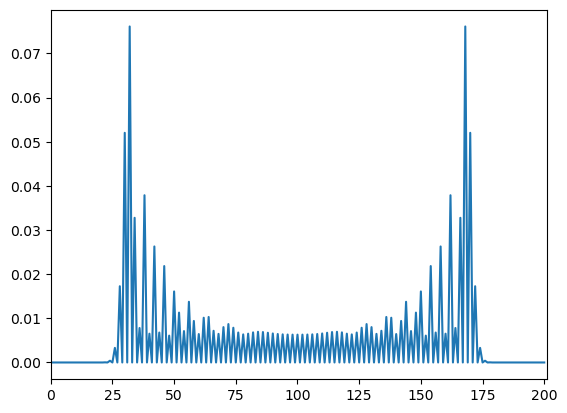

In [19]:
N = 100     # number of random steps
P = 2*N+1    # number of positions
coin0 = np.array([1, 0])  # |0>
coin1 = np.array([0, 1])  # |1>
C00 = np.outer(coin0, coin0)  # |0><0| 
C01 = np.outer(coin0, coin1)  # |0><1| 
C10 = np.outer(coin1, coin0)  # |1><0| 
C11 = np.outer(coin1, coin1)  # |1><1|
C_hat = (C00 + C01 + C10 - C11)/np.sqrt(2.)
ShiftPlus = np.roll(np.eye(P), 1, axis=0)
ShiftMinus = np.roll(np.eye(P), -1, axis=0)
S_hat = np.kron(ShiftPlus, C00) + np.kron(ShiftMinus, C11)
U = S_hat.dot(np.kron(np.eye(P), C_hat))
posn0 = np.zeros(P)
posn0[N] = 1     # array indexing starts from 0, so index N is the central posn
psi0 = np.kron(posn0,(coin0+coin1*1j)/np.sqrt(2.))
psiN = np.linalg.matrix_power(U, N).dot(psi0)
prob = np.empty(P)
for k in range(P):
    posn = np.zeros(P)
    posn[k] = 1     
    M_hat_k = np.kron( np.outer(posn,posn), np.eye(2))
    proj = M_hat_k.dot(psiN)
    prob[k] = proj.dot(proj.conjugate()).real

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(np.arange(P), prob)
#plt.plot(np.arange(P), prob, 'o')
#plt.loc = range (0, P, P / 10) #Location of ticks
#plt.xticks(loc)
plt.xlim(0, P)
#ax.set_xticklabels(range (-N, N+1, P / 10))

plt.show()

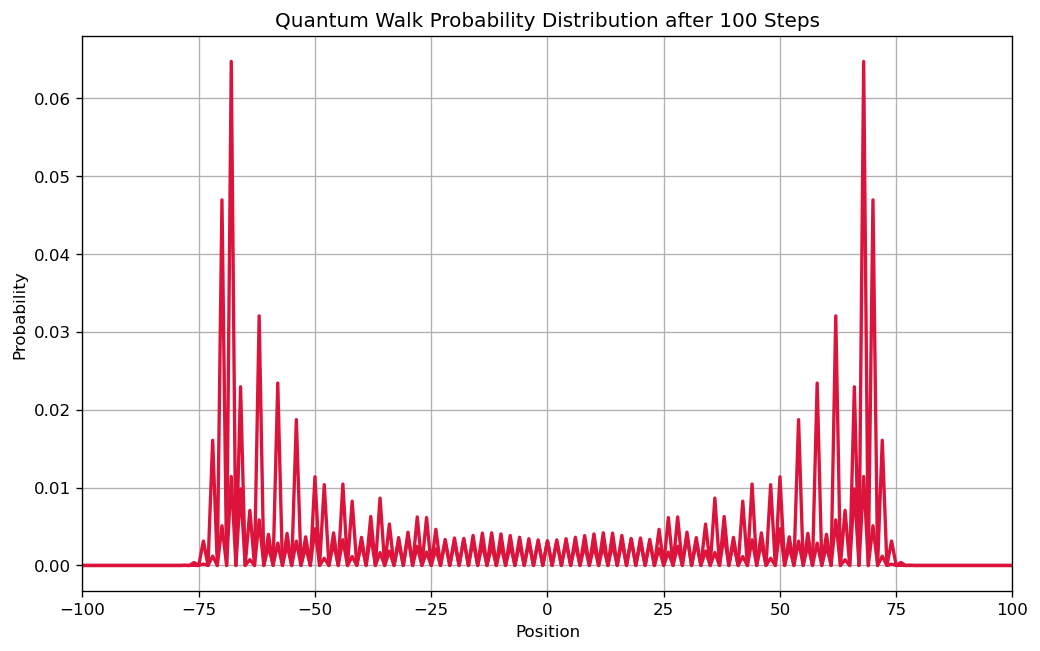

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 100            # number of steps
P = 2 * N + 1      # number of positions
center_position = N

# Define coin states and coin operator
coin0, coin1 = np.array([1, 0]), np.array([0, 1])
C00, C01 = np.outer(coin0, coin0), np.outer(coin0, coin1)
C10, C11 = np.outer(coin1, coin0), np.outer(coin1, coin1)
C_hat = (C00 + C01 + C10 - C11) / np.sqrt(2)

# Define shift operators
ShiftPlus = np.roll(np.eye(P), 1, axis=0)
ShiftMinus = np.roll(np.eye(P), -1, axis=0)
S_hat = np.kron(ShiftPlus, C00) + np.kron(ShiftMinus, C11)

# Time evolution operator
U = S_hat.dot(np.kron(np.eye(P), C_hat))

# Initial state: particle at center with equal superposition in coin space
posn0 = np.zeros(P)
posn0[center_position] = 1
psi0 = np.kron(posn0, (coin0 + 1j * coin1) / np.sqrt(2))

# Final state after N steps
psiN = np.linalg.matrix_power(U, N).dot(psi0)

# Probability distribution calculation
prob = np.array([np.abs(np.kron(np.eye(P)[:,k], np.eye(2)).dot(psiN))**2 for k in range(P)]).real

# Plotting
fig, ax = plt.subplots(figsize=(10, 6), dpi=120)
positions = np.arange(-N, N + 1)
ax.plot(positions, prob,color='#DC143C', lw=2)

# Enhancing plot details
ax.set_xlim(-N, N)
ax.set_xlabel('Position')
ax.set_ylabel('Probability')
ax.set_title('Quantum Walk Probability Distribution after {} Steps'.format(N))
ax.grid(True)

# Display plot
plt.show()


ValueError: x and y must have same first dimension, but have shapes (101,) and (201, 2)

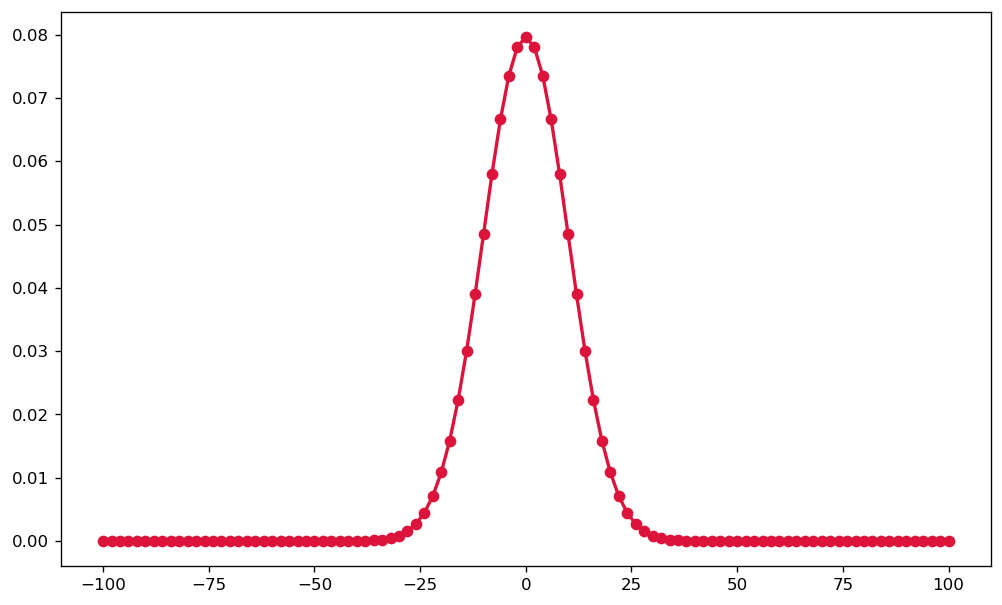

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

# Parameters
N = 100           # number of steps
positions = np.arange(-N, N + 1, 2)  # possible positions (even steps only)

# Classical random walk probability distribution (binomial distribution)
probabilities = binom.pmf((positions + N) // 2, N, 0.5)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6), dpi=120)
ax.plot(positions, probabilities, 'o-', color='#DC143C', lw=2)
ax.plot(positions, prob,color='#DC143C', lw=2)
# Enhancing plot details
ax.set_xlim(-N, N)
ax.set_xlabel('Position')
ax.set_ylabel('Probability')
ax.set_title('Classical Random Walk Probability Distribution after {} Steps'.format(N))
ax.grid(True)

# Display plot
plt.show()


(201,)
(101,)


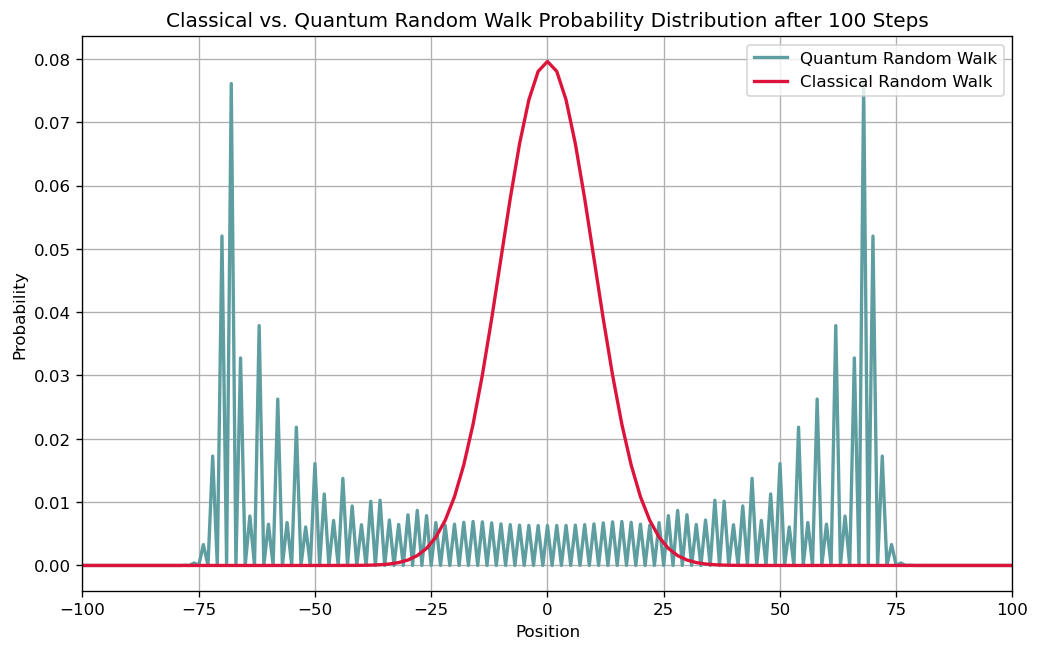

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

# Parameters
N = 100           # number of steps
P = 2 * N + 1     # number of positions

# Classical random walk (binomial distribution)
positions = np.arange(-N, N + 1, 2)  # even steps only for classical walk
probabilities_classical = binom.pmf((positions + N) // 2, N, 0.5)

# Quantum random walk optimized setup
coin0 = np.array([1, 0])
coin1 = np.array([0, 1])
C00 = np.outer(coin0, coin0)
C01 = np.outer(coin0, coin1)
C10 = np.outer(coin1, coin0)
C11 = np.outer(coin1, coin1)
C_hat = (C00 + C01 + C10 - C11) / np.sqrt(2)
ShiftPlus = np.roll(np.eye(P), 1, axis=0)
ShiftMinus = np.roll(np.eye(P), -1, axis=0)
S_hat = np.kron(ShiftPlus, C00) + np.kron(ShiftMinus, C11)
U = S_hat @ np.kron(np.eye(P), C_hat)
posn0 = np.zeros(P)
posn0[N] = 1
psi0 = np.kron(posn0, (coin0 + coin1 * 1j) / np.sqrt(2))
psiN = np.linalg.matrix_power(U, N) @ psi0
probabilities_quantum = np.array([np.abs(np.kron(np.eye(P)[:, k], np.eye(2)) @ psiN)**2 for k in range(P)])
probabilities_quantum = np.sum(probabilities_quantum, axis=1)
print(probabilities_quantum.shape)
print(probabilities_classical.shape)
# Plotting
fig, ax = plt.subplots(figsize=(10, 6), dpi=120)

# Plot classical and quantum walks

ax.plot(np.arange(P) - N, probabilities_quantum, color='#5F9EA0', lw=2, label='Quantum Random Walk')  # Cadetblue
ax.plot(positions, probabilities_classical, color='#DC143C', lw=2, label='Classical Random Walk')  # Crimson
# Enhancing plot details
ax.set_xlim(-N, N)
ax.set_xlabel('Position')
ax.set_ylabel('Probability')
ax.set_title(f'Classical vs. Quantum Random Walk Probability Distribution after {N} Steps')
ax.grid(True)

# Add legend only once
ax.legend()

# Display plot
plt.show()




